In [1]:
import sys
sys.path.append('..')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
import taiko as tk
from taiko.tools.config import *
from taiko.play import get_play, get_similarity
from taiko.database import load_record_df

from itertools import product
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import posixpath
import multiprocessing
from sklearn.preprocessing import StandardScaler

sns.set(font_scale=1.5)

Using TensorFlow backend.


In [3]:
SONG_ID = 1

In [4]:
record_df = load_record_df(song_id=SONG_ID)
record_df

,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime
1,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05
5,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13
9,aaaaa,1,L_2018-09-28_114340.csv,R_2018-09-28_114340.csv,capture_2018_09_28_11_43_41
13,aaaaa,1,L_2018-09-28_115822.csv,R_2018-09-28_115823.csv,capture_2018_09_28_11_58_23
25,carolyn,1,L_2018-09-27_154913.csv,R_2018-09-27_154916.csv,capture_2018_09_27_15_49_16
29,carolyn,1,L_2018-09-27_160509.csv,R_2018-09-27_160510.csv,capture_2018_09_27_16_05_10
33,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26
37,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11
42,celiven,1,L_2018-09-22_141822.csv,R_2018-09-22_141821.csv,capture_2018_09_22_14_18_21
46,celiven,1,L_2018-09-22_142958.csv,R_2018-09-22_142957.csv,capture_2018_09_22_14_29_57


In [5]:
play_result_df = pd.read_csv(PLAY_RESULT_TABLE_PATH)
play_result_df.drop(['drummer_name', 'song_id', 'capture_datetime'], axis=1, inplace=True)
play_record_df = record_df.merge(play_result_df, left_index=True, right_on='id', how='inner')
play_record_df['note'] = play_record_df['good'] + play_record_df['ok'] + play_record_df['bad']
play_record_df = play_record_df[play_record_df['note'] == ALL_NOTE_COUNT_DICT[SONG_ID]]
play_record_df.drop('note', axis=1, inplace=True)
play_record_df

,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime,id,p_order,score,good,ok,bad,max_combo,drumroll
0,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05,1,1,975110,81,5,0,86,78
4,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13,5,2,989360,84,2,0,86,63
8,aaaaa,1,L_2018-09-28_114340.csv,R_2018-09-28_114340.csv,capture_2018_09_28_11_43_41,9,3,979660,84,2,0,86,68
12,aaaaa,1,L_2018-09-28_115822.csv,R_2018-09-28_115823.csv,capture_2018_09_28_11_58_23,13,4,991060,84,2,0,86,74
16,carolyn,1,L_2018-09-27_154913.csv,R_2018-09-27_154916.csv,capture_2018_09_27_15_49_16,25,1,792630,54,30,2,84,42
20,carolyn,1,L_2018-09-27_160509.csv,R_2018-09-27_160510.csv,capture_2018_09_27_16_05_10,29,2,803450,57,25,4,61,48
24,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26,33,3,945560,76,10,0,86,49
28,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11,37,4,913960,71,15,0,86,47
32,celiven,1,L_2018-09-22_141822.csv,R_2018-09-22_141821.csv,capture_2018_09_22_14_18_21,42,1,978860,82,4,0,86,94
35,celiven,1,L_2018-09-22_142958.csv,R_2018-09-22_142957.csv,capture_2018_09_22_14_29_57,46,2,994710,85,1,0,86,95


In [6]:
full_combo_df = play_record_df[play_record_df['bad'] == 0]
full_combo_df

,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime,id,p_order,score,good,ok,bad,max_combo,drumroll
0,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05,1,1,975110,81,5,0,86,78
4,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13,5,2,989360,84,2,0,86,63
8,aaaaa,1,L_2018-09-28_114340.csv,R_2018-09-28_114340.csv,capture_2018_09_28_11_43_41,9,3,979660,84,2,0,86,68
12,aaaaa,1,L_2018-09-28_115822.csv,R_2018-09-28_115823.csv,capture_2018_09_28_11_58_23,13,4,991060,84,2,0,86,74
24,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26,33,3,945560,76,10,0,86,49
28,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11,37,4,913960,71,15,0,86,47
32,celiven,1,L_2018-09-22_141822.csv,R_2018-09-22_141821.csv,capture_2018_09_22_14_18_21,42,1,978860,82,4,0,86,94
35,celiven,1,L_2018-09-22_142958.csv,R_2018-09-22_142957.csv,capture_2018_09_22_14_29_57,46,2,994710,85,1,0,86,95
38,celiven,1,L_2018-09-22_144040.csv,R_2018-09-22_144039.csv,capture_2018_09_22_14_40_39,50,3,989460,84,2,0,86,94
40,celiven,1,L_2018-09-22_145139.csv,R_2018-09-22_145139.csv,capture_2018_09_22_14_51_38,54,4,999560,86,0,0,86,50


In [7]:
# test
# CONSIDERED_IDS = [61, 150]

# doraemon individual
# CONSIDERED_IDS = [1, 33, 61, 99, 150, 180, 241, 254, 288, 323]

# doraemon individual for two occurance
# CONSIDERED_IDS = [1, 5, 33, 37, 61, 65, 99, 107, 141, 150, 180, 181, 241, 249, 254, 258, 288, 310, 323, 327]

# RPG individual for two occurance
# CONSIDERED_IDS = [10, 14, 52, 56, 79, 83, 121, 125, 155, 159, 208, 216, 280, 284, 311, 315, 350, 354]

# all
CONSIDERED_IDS = play_record_df['id'].values

# full_combo
# CONSIDERED_IDS = full_combo_df['id'].values

CONSIDERED_IDS

array([  1,   5,   9,  13,  25,  29,  33,  37,  42,  46,  50,  54,  61,
        65,  69,  76,  78,  82,  86,  90,  95,  99, 103, 107, 112, 116,
       120, 124, 129, 133, 137, 141, 146, 150, 154, 158, 163, 167, 171,
       175, 179, 180, 181, 182, 203, 207, 211, 215, 224, 228, 232, 237,
       241, 245, 249, 254, 258, 262, 266, 271, 275, 279, 283, 288, 292,
       296, 300, 306, 310, 314, 318, 323, 327, 331, 335, 341, 345, 349,
       353])

In [8]:
plays = []
with multiprocessing.Pool() as p:
    for _, play in tqdm(enumerate(p.imap(get_play, CONSIDERED_IDS)), total=len(CONSIDERED_IDS)):
        plays.append(play)

play_record_df[play_record_df['id'].isin(CONSIDERED_IDS)]

100%|██████████| 79/79 [03:12<00:00,  2.43s/it]


,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime,id,p_order,score,good,ok,bad,max_combo,drumroll
0,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05,1,1,975110,81,5,0,86,78
4,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13,5,2,989360,84,2,0,86,63
8,aaaaa,1,L_2018-09-28_114340.csv,R_2018-09-28_114340.csv,capture_2018_09_28_11_43_41,9,3,979660,84,2,0,86,68
12,aaaaa,1,L_2018-09-28_115822.csv,R_2018-09-28_115823.csv,capture_2018_09_28_11_58_23,13,4,991060,84,2,0,86,74
16,carolyn,1,L_2018-09-27_154913.csv,R_2018-09-27_154916.csv,capture_2018_09_27_15_49_16,25,1,792630,54,30,2,84,42
20,carolyn,1,L_2018-09-27_160509.csv,R_2018-09-27_160510.csv,capture_2018_09_27_16_05_10,29,2,803450,57,25,4,61,48
24,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26,33,3,945560,76,10,0,86,49
28,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11,37,4,913960,71,15,0,86,47
32,celiven,1,L_2018-09-22_141822.csv,R_2018-09-22_141821.csv,capture_2018_09_22_14_18_21,42,1,978860,82,4,0,86,94
35,celiven,1,L_2018-09-22_142958.csv,R_2018-09-22_142957.csv,capture_2018_09_22_14_29_57,46,2,994710,85,1,0,86,95


In [9]:
HANDS = ['L', 'R']
_K = 370
SIMILARITY_COLUMNS = [a + '_' + b for a, b in product(HANDS, ZERO_ADJ_COL)]
SIMILARITY_COLUMNS = [str(k) + '_' + b for k, b in product(range(_K), SIMILARITY_COLUMNS)]
SIMILARITY_COLUMNS

['0_L_imu_ax',
 '0_L_imu_ay',
 '0_L_imu_az',
 '0_L_imu_gx',
 '0_L_imu_gy',
 '0_L_imu_gz',
 '0_R_imu_ax',
 '0_R_imu_ay',
 '0_R_imu_az',
 '0_R_imu_gx',
 '0_R_imu_gy',
 '0_R_imu_gz',
 '1_L_imu_ax',
 '1_L_imu_ay',
 '1_L_imu_az',
 '1_L_imu_gx',
 '1_L_imu_gy',
 '1_L_imu_gz',
 '1_R_imu_ax',
 '1_R_imu_ay',
 '1_R_imu_az',
 '1_R_imu_gx',
 '1_R_imu_gy',
 '1_R_imu_gz',
 '2_L_imu_ax',
 '2_L_imu_ay',
 '2_L_imu_az',
 '2_L_imu_gx',
 '2_L_imu_gy',
 '2_L_imu_gz',
 '2_R_imu_ax',
 '2_R_imu_ay',
 '2_R_imu_az',
 '2_R_imu_gx',
 '2_R_imu_gy',
 '2_R_imu_gz',
 '3_L_imu_ax',
 '3_L_imu_ay',
 '3_L_imu_az',
 '3_L_imu_gx',
 '3_L_imu_gy',
 '3_L_imu_gz',
 '3_R_imu_ax',
 '3_R_imu_ay',
 '3_R_imu_az',
 '3_R_imu_gx',
 '3_R_imu_gy',
 '3_R_imu_gz',
 '4_L_imu_ax',
 '4_L_imu_ay',
 '4_L_imu_az',
 '4_L_imu_gx',
 '4_L_imu_gy',
 '4_L_imu_gz',
 '4_R_imu_ax',
 '4_R_imu_ay',
 '4_R_imu_az',
 '4_R_imu_gx',
 '4_R_imu_gy',
 '4_R_imu_gz',
 '5_L_imu_ax',
 '5_L_imu_ay',
 '5_L_imu_az',
 '5_L_imu_gx',
 '5_L_imu_gy',
 '5_L_imu_gz',
 '5_R_imu_

In [10]:
similarity_mat = []
with multiprocessing.Pool() as p:
    result = p.starmap(get_similarity, product(plays, repeat=2))
    ids = list(product(CONSIDERED_IDS, repeat=2))
    for ids_, sim in zip(ids, result):
        similarity_mat.append(list(ids_) + list(sim))
#         sim = get_similarity(row1[1], row2[1])
#         similarity_mat.append([row1[0], row2[0], sim[0], sim[1]])
#         print(sim)

similarity_df = pd.DataFrame(data=similarity_mat)
similarity_df.columns = ['a_id', 'b_id'] + SIMILARITY_COLUMNS
similarity_df

,a_id,b_id,0_L_imu_ax,0_L_imu_ay,0_L_imu_az,0_L_imu_gx,0_L_imu_gy,0_L_imu_gz,0_R_imu_ax,0_R_imu_ay,...,369_L_imu_az,369_L_imu_gx,369_L_imu_gy,369_L_imu_gz,369_R_imu_ax,369_R_imu_ay,369_R_imu_az,369_R_imu_gx,369_R_imu_gy,369_R_imu_gz
0,1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,5,2.924983,5.572706,3.737061,63.204431,110.386542,28.642757,2.815819,6.105488,...,17.669147,10.478993,28.308160,32.288409,1.201969,4.820462,17.188714,20.162659,50.605301,33.023976
2,1,9,2.972723,6.482238,3.387341,38.312355,142.248065,96.021124,4.331637,3.187471,...,20.187053,93.781403,377.738102,260.120600,1.422395,7.984780,29.169768,48.248750,199.864719,177.942997
3,1,13,3.073409,3.741426,4.351752,67.987481,106.834304,21.821630,2.993695,4.058232,...,17.493656,18.029433,35.235016,21.760249,0.692784,3.214220,17.667679,17.841399,38.642855,14.517517
4,1,25,2.986022,27.982029,5.362592,149.400927,105.550901,13.758942,3.911642,28.796405,...,23.465450,18.731096,31.073902,15.760917,0.723402,4.979004,23.686819,27.481304,39.337820,18.847527
5,1,29,5.674886,15.600580,5.140136,63.494577,101.877517,11.289831,4.406143,15.640265,...,26.362420,18.225901,31.417988,14.833307,4.659286,5.857779,26.571878,24.148763,40.074306,16.717140
6,1,33,10.169589,11.184191,4.777461,124.699450,161.459841,96.109019,3.205315,12.089189,...,17.897770,17.998164,32.330166,27.927642,1.387638,8.263089,18.442148,15.603448,78.247844,32.000161
7,1,37,3.283723,3.698440,2.809924,59.195087,107.441009,30.786548,2.771017,4.033552,...,22.500267,27.854075,24.070765,27.338992,1.427862,2.904193,22.222839,30.104379,49.327347,20.819719
8,1,42,2.430667,6.859495,10.603994,63.316480,113.181730,33.206035,3.128523,7.325983,...,14.053141,216.736042,494.419484,515.790697,13.442951,29.316034,18.100712,190.843071,448.757604,452.908908
9,1,46,23.352885,8.176901,39.758536,220.813747,542.811661,240.874679,20.375507,6.176490,...,44.981597,61.901503,48.410983,115.104139,2.286654,24.945515,46.764515,123.981840,41.858970,50.727119


In [11]:
dtw_df = similarity_df.copy()
dtw_df['same'] = (dtw_df['a_id'] == dtw_df['b_id'])
dtw_df = dtw_df[~dtw_df['same']].drop('same', axis=1)
# for col in SIMILARITY_COLUMNS:
#     sns.distplot(dtw_df[col])
#     plt.show()

In [12]:
scaler = StandardScaler()
dtw_df[SIMILARITY_COLUMNS] = scaler.fit_transform(dtw_df[SIMILARITY_COLUMNS])
# dtw_df['acc_dtw'] -= dtw_df.min(axis=0)['acc_dtw']
# dtw_df['gyr_dtw'] -= dtw_df.min(axis=0)['gyr_dtw']
dtw_df['norm_sim'] = dtw_df[SIMILARITY_COLUMNS].mean(axis=1)
dtw_df

,a_id,b_id,0_L_imu_ax,0_L_imu_ay,0_L_imu_az,0_L_imu_gx,0_L_imu_gy,0_L_imu_gz,0_R_imu_ax,0_R_imu_ay,...,369_L_imu_gx,369_L_imu_gy,369_L_imu_gz,369_R_imu_ax,369_R_imu_ay,369_R_imu_az,369_R_imu_gx,369_R_imu_gy,369_R_imu_gz,norm_sim
1,1,5,-0.613823,-0.581783,-0.524481,-0.447506,0.065007,-0.629137,-0.663830,-0.485261,...,-0.998248,-0.877583,-0.740406,-1.143470,-0.935396,0.322954,-0.875812,-0.721368,-0.677788,0.149962
2,1,9,-0.603563,-0.473899,-0.571848,-0.670452,0.376279,-0.009951,-0.316788,-0.833380,...,-0.306808,2.114422,1.031675,-1.103203,-0.660423,1.414973,-0.637550,0.893234,0.484467,0.179457
3,1,13,-0.581925,-0.799000,-0.441225,-0.404666,0.030303,-0.691821,-0.623105,-0.729498,...,-0.935577,-0.818271,-0.822294,-1.236486,-1.074975,0.366610,-0.895504,-0.850771,-0.826211,0.004256
4,1,25,-0.600705,2.076297,-0.304314,0.324514,0.017765,-0.765915,-0.412945,2.221759,...,-0.929753,-0.853901,-0.868957,-1.230893,-0.921619,0.915227,-0.813726,-0.843253,-0.791484,0.068517
5,1,29,-0.022843,0.607672,-0.334444,-0.444907,-0.018122,-0.788605,-0.299731,0.652235,...,-0.933946,-0.850955,-0.876172,-0.511894,-0.845255,1.178187,-0.841997,-0.835286,-0.808569,0.156974
6,1,33,0.943111,0.083823,-0.383566,0.103275,0.563969,-0.009144,-0.574656,0.228593,...,-0.935836,-0.843144,-0.774324,-1.109552,-0.636238,0.437199,-0.914489,-0.422347,-0.685999,0.030110
7,1,37,-0.536726,-0.804099,-0.650056,-0.483416,0.036230,-0.609436,-0.674087,-0.732442,...,-0.854029,-0.913866,-0.778902,-1.102204,-1.101916,0.781792,-0.791474,-0.735192,-0.775667,0.026566
8,1,42,-0.720056,-0.429151,0.405599,-0.446502,0.092315,-0.587202,-0.592237,-0.339656,...,0.713760,3.113509,3.020280,1.092688,1.193222,0.406079,0.572116,3.585613,2.689702,0.559054
9,1,46,3.776327,-0.272887,4.354386,0.964123,4.289594,1.321207,3.356399,-0.476790,...,-0.571423,-0.705452,-0.096264,-0.945322,0.813432,3.018653,0.004914,-0.815981,-0.535808,0.451364
10,1,50,-0.705741,-1.062101,-0.783060,-0.190762,1.620643,-0.556516,-0.173664,-1.013248,...,1.412605,0.639758,0.335418,0.571843,-0.914941,3.038455,1.443660,1.132706,-0.085059,0.454668


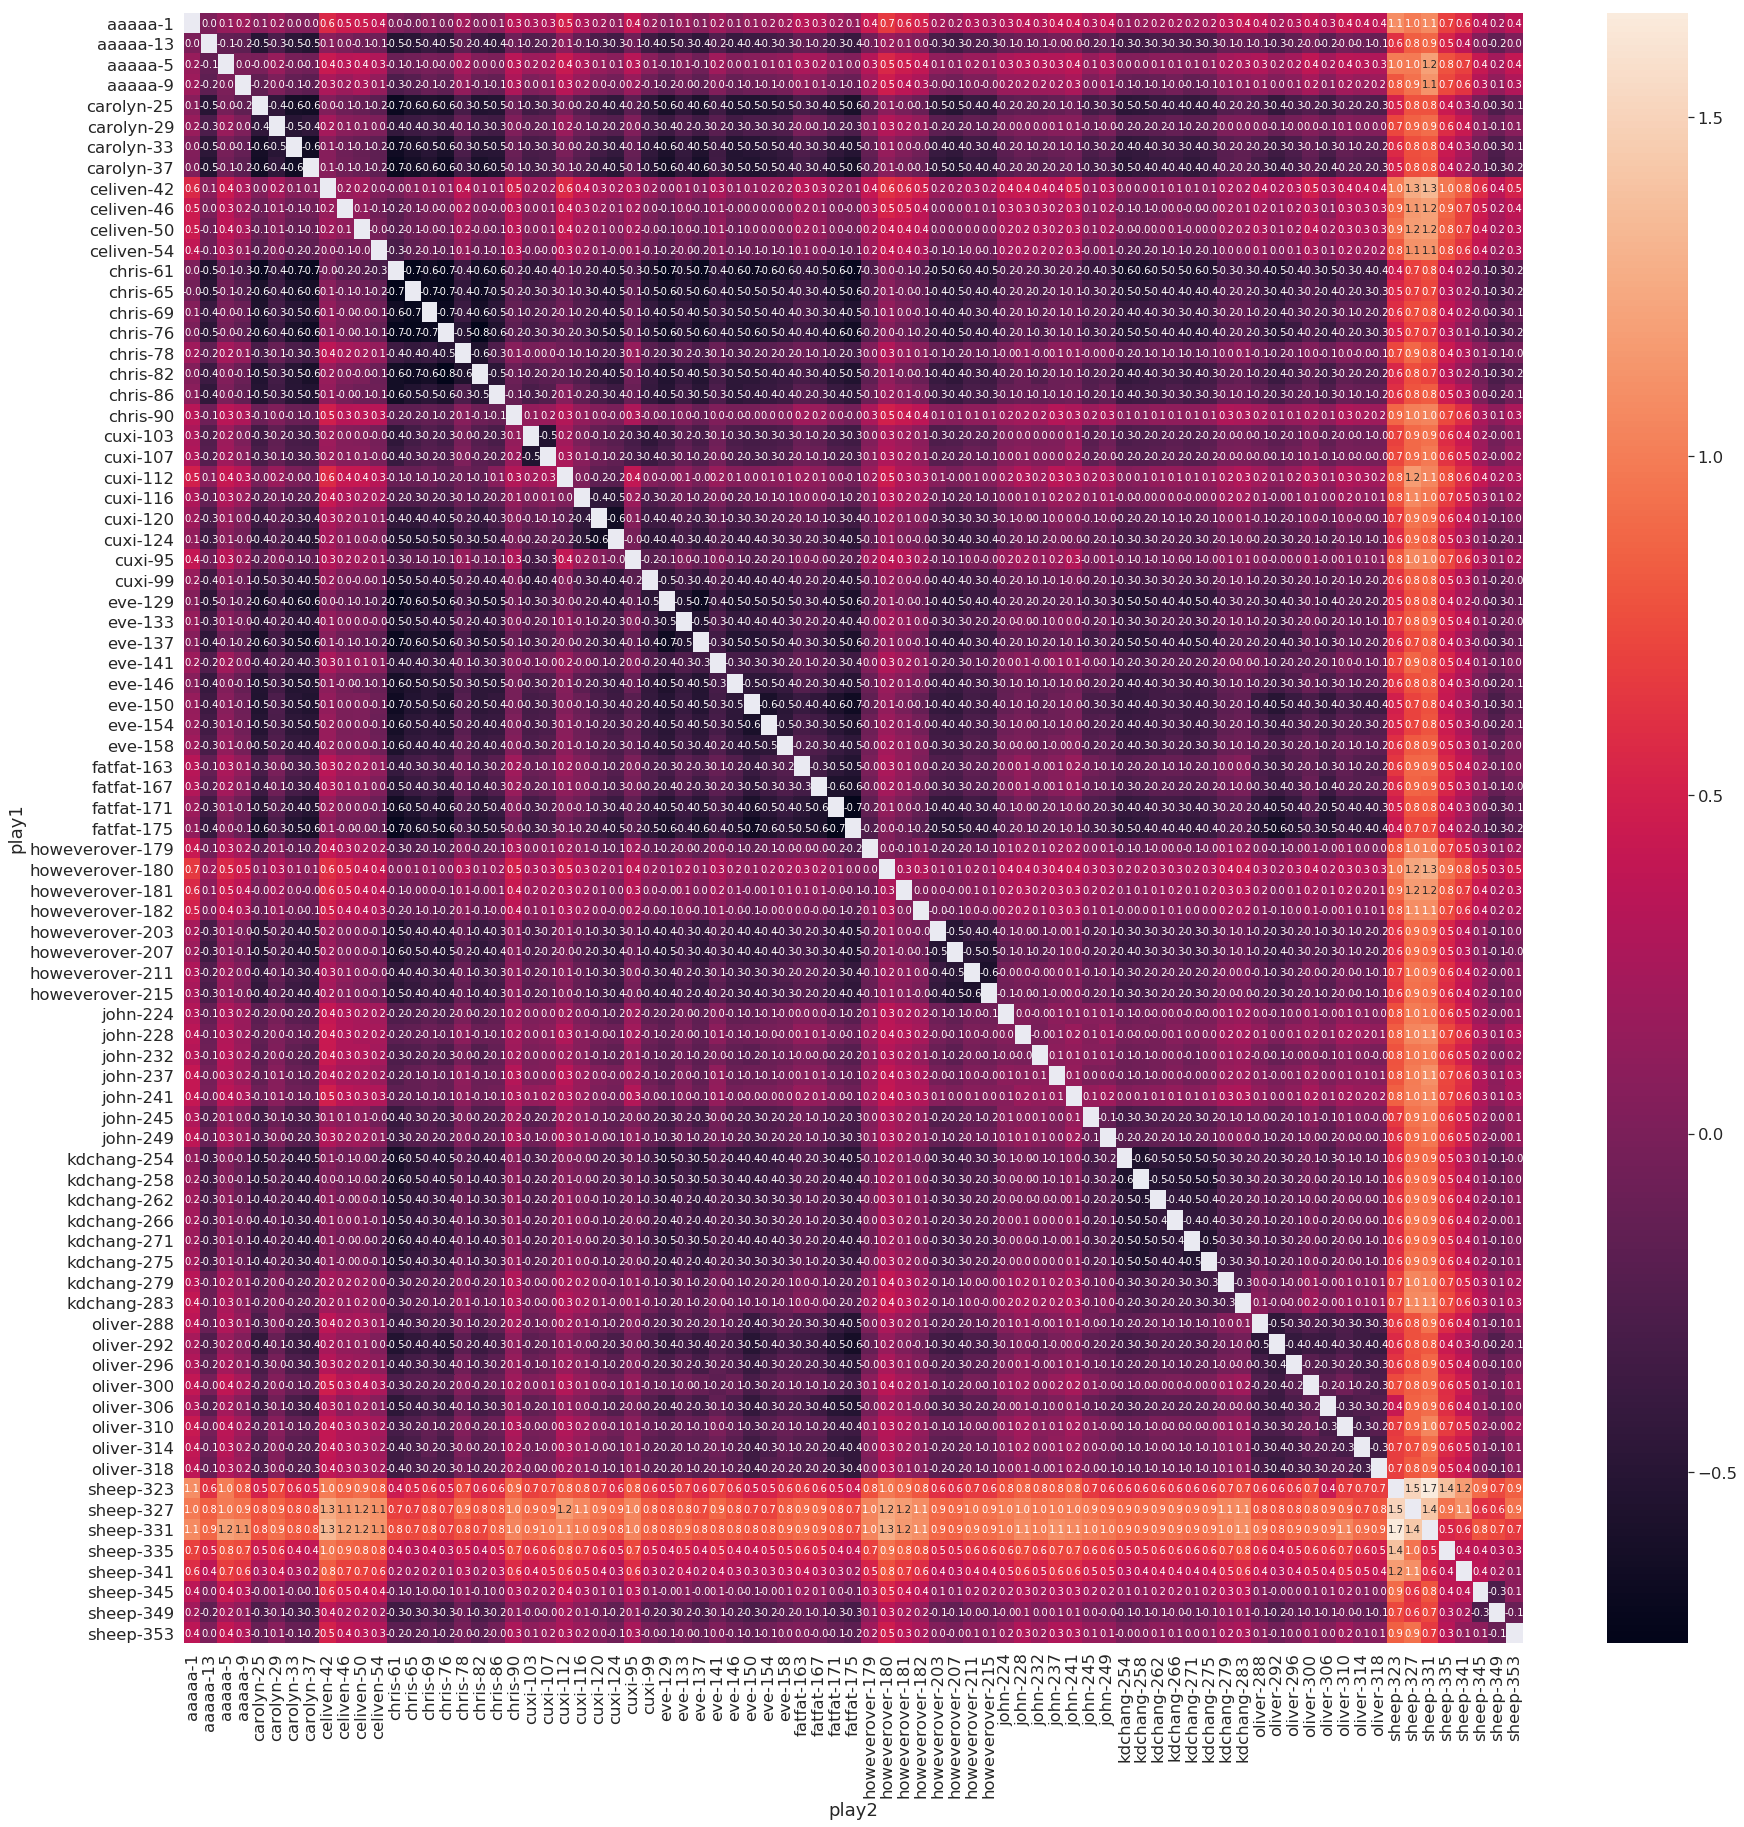

In [13]:
vis_right_df = play_record_df.copy()
vis_right_df = vis_right_df[['drummer_name', 'id']]

vis_df = dtw_df.merge(vis_right_df, left_on='a_id', right_on='id', how='inner')
vis_df = vis_df.merge(vis_right_df, left_on='b_id', right_on='id', how='inner')
vis_df.drop(['id_x', 'id_y'], axis=1, inplace=True)
vis_df = vis_df.rename(index=str, columns={'drummer_name_x': 'a_drummer_name',
                                  'drummer_name_y': 'b_drummer_name'})
vis_df['a_id'] = vis_df['a_id'].apply(str)
vis_df['b_id'] = vis_df['b_id'].apply(str)
vis_df['play1'] = vis_df[['a_drummer_name', 'a_id']].apply(lambda x: '-'.join(x), axis=1)
vis_df['play2'] = vis_df[['b_drummer_name', 'b_id']].apply(lambda x: '-'.join(x), axis=1)
vis_df = vis_df.pivot('play1', 'play2', 'norm_sim')
plt.figure(figsize=(30, 30))
ax = sns.heatmap(vis_df, annot=True, fmt='.1f')

# LGBM

In [14]:
import lightgbm as lgb
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [15]:
score_right_df = play_record_df.copy()
score_right_df = score_right_df[['score', 'id']]

score_df = dtw_df.copy()
score_df = score_df.merge(score_right_df, left_on='a_id', right_on='id', how='inner')
score_df = score_df.merge(score_right_df, left_on='b_id', right_on='id', how='inner')
score_df = score_df[score_df['a_id'] < score_df['b_id']].reset_index(drop=True)
score_df.drop(['id_x', 'id_y'], axis=1, inplace=True)
score_df['score_dif'] = np.abs(score_df['score_x'] - score_df['score_y'])
score_df.drop(['score_x', 'score_y'], axis=1, inplace=True)
score_df

,a_id,b_id,0_L_imu_ax,0_L_imu_ay,0_L_imu_az,0_L_imu_gx,0_L_imu_gy,0_L_imu_gz,0_R_imu_ax,0_R_imu_ay,...,369_L_imu_gy,369_L_imu_gz,369_R_imu_ax,369_R_imu_ay,369_R_imu_az,369_R_imu_gx,369_R_imu_gy,369_R_imu_gz,norm_sim,score_dif
0,1,5,-0.613823,-0.581783,-0.524481,-0.447506,0.065007,-0.629137,-0.663830,-0.485261,...,-0.877583,-0.740406,-1.143470,-0.935396,0.322954,-0.875812,-0.721368,-0.677788,0.149962,14250
1,1,9,-0.603563,-0.473899,-0.571848,-0.670452,0.376279,-0.009951,-0.316788,-0.833380,...,2.114422,1.031675,-1.103203,-0.660423,1.414973,-0.637550,0.893234,0.484467,0.179457,4550
2,5,9,-0.700737,-1.015684,-0.866153,-0.659528,-0.535149,0.237447,-0.528704,-0.803852,...,1.955101,0.929691,-1.122934,-1.079755,-0.194009,-0.465882,0.720016,0.290189,0.004849,9700
3,1,13,-0.581925,-0.799000,-0.441225,-0.404666,0.030303,-0.691821,-0.623105,-0.729498,...,-0.818271,-0.822294,-1.236486,-1.074975,0.366610,-0.895504,-0.850771,-0.826211,0.004256,15950
4,5,13,-1.174185,-1.014856,-0.931174,-0.926100,-0.926345,-0.804629,-1.211329,-0.964294,...,-0.931817,-0.680830,-1.186465,-0.688045,-1.133830,-0.829216,-0.961186,-0.683401,-0.134724,1700
5,9,13,-0.680320,-0.895592,-0.805611,-0.626504,-0.529868,0.164418,-0.531248,-1.013320,...,1.858298,1.123874,-1.184740,-0.447223,-0.234842,-0.647443,0.575082,0.464769,-0.163246,11400
6,1,25,-0.600705,2.076297,-0.304314,0.324514,0.017765,-0.765915,-0.412945,2.221759,...,-0.853901,-0.868957,-1.230893,-0.921619,0.915227,-0.813726,-0.843253,-0.791484,0.068517,182480
7,5,25,-0.803822,2.730178,-0.790646,-0.165566,-0.909908,-0.571415,-0.685217,2.941440,...,-0.934232,-0.750318,-1.173270,-1.248354,-0.681345,-0.788633,-0.957481,-0.722130,-0.018406,196730
8,9,25,-0.749596,2.803858,-0.674781,0.074405,-0.500709,-0.070753,0.054532,2.572515,...,1.910397,1.005236,-1.168054,-1.059496,-0.716051,-0.604353,0.623869,0.434979,-0.156949,187030
9,13,25,-0.772732,2.506796,-0.873366,-0.242169,-0.909547,-0.643226,-0.653062,2.694279,...,-1.059595,-0.870135,-1.321164,-0.654708,-0.730058,-0.959057,-1.227687,-0.880439,-0.490560,198430


In [16]:
train_df = score_df.drop(['a_id', 'b_id', 'norm_sim'], axis=1).copy()
x = train_df.drop('score_dif', axis=1)
y = train_df['score_dif']

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, test_size=0.2)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, random_state=0, test_size=0.5)

train_df

,0_L_imu_ax,0_L_imu_ay,0_L_imu_az,0_L_imu_gx,0_L_imu_gy,0_L_imu_gz,0_R_imu_ax,0_R_imu_ay,0_R_imu_az,0_R_imu_gx,...,369_L_imu_gx,369_L_imu_gy,369_L_imu_gz,369_R_imu_ax,369_R_imu_ay,369_R_imu_az,369_R_imu_gx,369_R_imu_gy,369_R_imu_gz,score_dif
0,-0.613823,-0.581783,-0.524481,-0.447506,0.065007,-0.629137,-0.663830,-0.485261,-0.636129,-0.813215,...,-0.998248,-0.877583,-0.740406,-1.143470,-0.935396,0.322954,-0.875812,-0.721368,-0.677788,14250
1,-0.603563,-0.473899,-0.571848,-0.670452,0.376279,-0.009951,-0.316788,-0.833380,-0.656518,-0.706068,...,-0.306808,2.114422,1.031675,-1.103203,-0.660423,1.414973,-0.637550,0.893234,0.484467,4550
2,-0.700737,-1.015684,-0.866153,-0.659528,-0.535149,0.237447,-0.528704,-0.803852,-0.770638,-0.864948,...,-0.308843,1.955101,0.929691,-1.122934,-1.079755,-0.194009,-0.465882,0.720016,0.290189,9700
3,-0.581925,-0.799000,-0.441225,-0.404666,0.030303,-0.691821,-0.623105,-0.729498,-0.586814,-0.852359,...,-0.935577,-0.818271,-0.822294,-1.236486,-1.074975,0.366610,-0.895504,-0.850771,-0.826211,15950
4,-1.174185,-1.014856,-0.931174,-0.926100,-0.926345,-0.804629,-1.211329,-0.964294,-0.845022,-0.911354,...,-0.910060,-0.931817,-0.680830,-1.186465,-0.688045,-1.133830,-0.829216,-0.961186,-0.683401,1700
5,-0.680320,-0.895592,-0.805611,-0.626504,-0.529868,0.164418,-0.531248,-1.013320,-0.712376,-0.783548,...,-0.453669,1.858298,1.123874,-1.184740,-0.447223,-0.234842,-0.647443,0.575082,0.464769,11400
6,-0.600705,2.076297,-0.304314,0.324514,0.017765,-0.765915,-0.412945,2.221759,-0.628937,-0.240085,...,-0.929753,-0.853901,-0.868957,-1.230893,-0.921619,0.915227,-0.813726,-0.843253,-0.791484,182480
7,-0.803822,2.730178,-0.790646,-0.165566,-0.909908,-0.571415,-0.685217,2.941440,-0.848961,-0.344475,...,-0.905223,-0.934232,-0.750318,-1.173270,-1.248354,-0.681345,-0.788633,-0.957481,-0.722130,196730
8,-0.749596,2.803858,-0.674781,0.074405,-0.500709,-0.070753,0.054532,2.572515,-0.754196,-0.379156,...,-0.455487,1.910397,1.005236,-1.168054,-1.059496,-0.716051,-0.604353,0.623869,0.434979,187030
9,-0.772732,2.506796,-0.873366,-0.242169,-0.909547,-0.643226,-0.653062,2.694279,-0.843581,-0.288095,...,-1.065595,-1.059595,-0.870135,-1.321164,-0.654708,-0.730058,-0.959057,-1.227687,-0.880439,198430


In [24]:
train_set = lgb.Dataset(x_train, y_train)
valid_set = lgb.Dataset(x_valid, y_valid, free_raw_data=False)
watchlist = [valid_set]

params = dict({
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'application': 'rmse',
#     'min_data_in_leaf': 3,
#     'max_depth': 100,
    'num_leaves': 2 ** 10,
#     'min_data': 1,
    'verbosity': 0,
#     'metric': ['l1']
})

grid_params = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [8, 10],
}

model = lgb.train(params, train_set=train_set, valid_sets=watchlist,
                  num_boost_round=500, verbose_eval=10, early_stopping_rounds=20)
y_pred = model.predict(x_test, num_iteration=model.best_iteration)

Training until validation scores don't improve for 20 rounds.
[10]	valid_0's rmse: 70293
[20]	valid_0's rmse: 60004
[30]	valid_0's rmse: 56703.5
[40]	valid_0's rmse: 55549.7
[50]	valid_0's rmse: 55066.7
[60]	valid_0's rmse: 54821.1
[70]	valid_0's rmse: 54690.5
[80]	valid_0's rmse: 54544.7
[90]	valid_0's rmse: 54403.6
[100]	valid_0's rmse: 54347.6
[110]	valid_0's rmse: 54329.3
[120]	valid_0's rmse: 54316.4
[130]	valid_0's rmse: 54318.1
[140]	valid_0's rmse: 54317.1
Early stopping, best iteration is:
[123]	valid_0's rmse: 54307.4


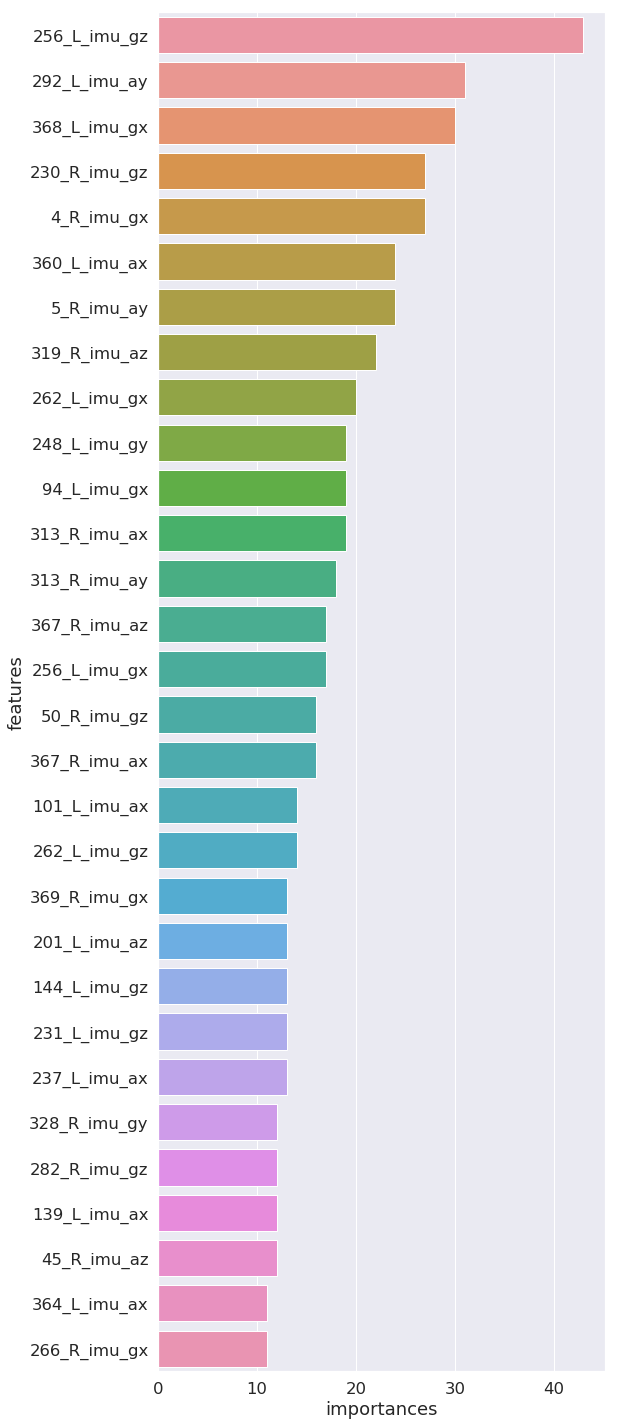

In [25]:
plot_df = pd.DataFrame({'features': train_df.columns[train_df.columns != 'score_dif'],
                        'importances': model.feature_importance()})
plot_df = plot_df.sort_values('importances', ascending=False)
plot_df = plot_df.head(30)
plt.figure(figsize=(8, 25))
sns.barplot(x = plot_df.importances, y = plot_df.features)
plt.show()

In [26]:
compare_df = pd.DataFrame(data={
    'pred': y_pred,
    'test': y_test,
})
compare_df['dif'] = np.abs(compare_df['pred'] - compare_df['test'])
compare_df.reset_index(inplace=True)
compare_df

,index,pred,test,dif
0,2001,166991.963657,211760,44768.036343
1,2669,16058.392213,15950,108.392213
2,1999,58472.458587,43700,14772.458587
3,2466,101745.150219,27380,74365.150219
4,1051,46561.565459,12700,33861.565459
5,2061,149056.356099,147950,1106.356099
6,2524,99301.755339,423400,324098.244661
7,1505,254791.822496,177880,76911.822496
8,2361,124814.968786,125840,1025.031214
9,10,111868.454883,171660,59791.545117


In [27]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [28]:
print('The mae of prediction is:', mean_absolute_error(y_test, y_pred))

The mae of prediction is: 39991.552123135305


In [29]:
print('The mape of prediction is:', mean_absolute_percentage_error(y_test, y_pred))

The mape of prediction is: 824.9243602722805
